In [1]:
#importing the required packages

import os
import warnings
import pandas as pd
import numpy as np 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Activation, MaxPooling1D, Conv1D, Input 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model

In [2]:
#importing the NLP packages
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
nltk.download('punkt')
nltk.download('stopwords')
stop= set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#downloading the data
!wget https://www.dropbox.com/sh/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla?dl=0

--2021-03-04 01:38:39--  https://www.dropbox.com/sh/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla [following]
--2021-03-04 01:38:39--  https://www.dropbox.com/sh/raw/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc233ca37410e79cc6c556e9722f.dl.dropboxusercontent.com/zip_download_get/AtaOTmWRmsAt5e6MZJbYO0rwkOKXjMi7LUv0ceFospkvV3mHx9i9scHUQwKYTGWvgfFgRhC-a_hwA0vtIZ_ShWMIbDND5iI39z7PF86RuxVi-Q [following]
--2021-03-04 01:38:40--  https://uc233ca37410e79cc6c556e9722f.dl.dropboxusercontent.com/zip_download_get/AtaOTmWRmsAt5e6MZJbYO0rwkOKXjMi7LUv0ceFospkvV3mHx9i9scHUQwKYTGWvgfFgRhC-a_hwA0vtI

In [4]:
#importing the daa 
file =open(r"/content/AAAw1_JIzpuVvwteJCma0xMla?dl=0" , "r" ,encoding="ISO-8859-1")


In [5]:
data = pd.read_csv(file)

In [6]:

data.tail()

,PK,question_text,target
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0.0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0.0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0.0
1306122,PKÐÞ¾±´>g´>gPK,NaN,NaN
1306123,?g,NaN,NaN


In [7]:
#checking the na values
data.target.isnull().value_counts()

False    1306122
True           2
Name: target, dtype: int64

In [8]:
data.target.value_counts()

0.0    1225312
1.0      80810
Name: target, dtype: int64

In [9]:
#dropingout the na values 
data.drop(data.tail(2).index, inplace = True)

In [10]:
#now data is cleaned 
data.tail(5)

,PK,question_text,target
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0.0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0.0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0.0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0.0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0.0


In [11]:
#converting float traget value into int
data.target= [round(a) for a in data.target]

In [12]:
data.head()

,PK,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [13]:
data.target.value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split
train_data , test_data = train_test_split(data, random_state = 42)

In [15]:
np.quantile(len(data.question_text),0.95)

1306122.0

In [16]:
#downloading the glove embeddings 
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-03-04 01:39:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-04 01:39:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-04 01:39:44--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [33]:
! unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [34]:
%ls

'AAAw1_JIzpuVvwteJCma0xMla?dl=0'   glove.6B.300d.txt   sample_data/
 glove.6B.100d.txt                 glove.6B.50d.txt
 glove.6B.200d.txt                 glove.6B.zip


In [35]:
#creating glove embedding index
embeddings_index = {}
glove_input_file = open('/content/glove.6B.300d.txt')
for line in glove_input_file:
  values = line.split(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
glove_input_file.close()

In [36]:
## Iterate over the data to preprocess by removing stopwords,  
corpus=[] 
for line in train_data['question_text'].values: 
  line = line.lower()
  line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
  review=[word for word in line_by_words if not word in stop]
  review=' '.join(review)
  corpus.append(review)
print(corpus[0:5])


['job prospects mim recent graduate without previous work experience', 'country spiritual', 'females prone goitre', 'contemporary use tree life', 'last months feeling tell someone school feel']


In [ ]:
#cheking max_sent lenght 
'''sent_lens=[]
for sent in train_data['question_text']:
    sent_lens.append(len(word_tokenize(sent)))

np.quantile(sent_lens, 0.95)'''


In [37]:

#vectorizing the text samples, giving a value to each word
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

max_num_words=2000
max_len = 100

tok = Tokenizer(num_words= max_num_words)

tok.fit_on_texts(corpus)





In [38]:
word_index =tok.word_index

In [39]:
sequences_data = tok.texts_to_sequences(corpus)

In [40]:
# unique words in a data 
vocab_len=len(tok.index_word.keys())
vocab_len

170897

In [41]:

#padding the lists, because all the neural networks require to have inputs of same size and shape  
from tensorflow.keras.preprocessing import sequence

sequences_matrix_data = pad_sequences(sequences_data,maxlen=max_len)
print(sequences_matrix_data.shape)

(979591, 100)


In [42]:
## Iterate over the data to preprocess by removing stopwords,  
test_corpus=[] 
for line in test_data['question_text'].values: 
  line = line.lower()
  line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
  review=[word for word in line_by_words if not word in stop]
  review=' '.join(review)
  test_corpus.append(review)
print(test_corpus[0:5])


['effective classroom management skill technique create good learning environment', 'study abroad 10th class bangladesh', 'make friends college junior', 'download free apk minecraft pocket edition ios iphone', 'like kuvera groww also free online investment platform invest direct mutual funds']


In [43]:
max_num_words=2000
max_len = 100

test_tok = Tokenizer(num_words= max_num_words)

test_tok.fit_on_texts(test_corpus)


In [44]:
word_index =test_tok.word_index

In [45]:
test_sequences_data = test_tok.texts_to_sequences(test_corpus)

In [46]:
vocab_len=len(test_tok.index_word.keys())
vocab_len

96069

In [47]:
#padding the lists, because all the neural networks require to have inputs of same size and shape  
from tensorflow.keras.preprocessing import sequence

test_sequences_matrix_data = pad_sequences(test_sequences_data,maxlen=max_len)
print(test_sequences_matrix_data.shape)

(326531, 100)


In [48]:
#preparing the embedding matrix
from keras.layers import Embedding
from keras.initializers import Constant

#Embedding dimention need to match the embedding index dimimention
Embedding_dim = embeddings_index.get('a').shape[0]
num_words = min(max_num_words, len(word_index)) + 1

embedding_matrix = np.zeros((num_words, Embedding_dim))
for word, i in word_index.items():
  if i > max_num_words:
    continue
  embedding_vector = embeddings_index.get(word)
    #references the loaded embeddings dictionary
  if embedding_vector is not None:
    #word not found in embedding index will be all-zeros
    embedding_matrix[i] = embedding_vector
    #load pretrained word embedding into an Embedding layer 
    #note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,  Embedding_dim , embeddings_initializer=Constant(embedding_matrix), input_length = max_len, trainable = False)



(2001, 300)


Text(0.5, 1.0, 'example vectors')

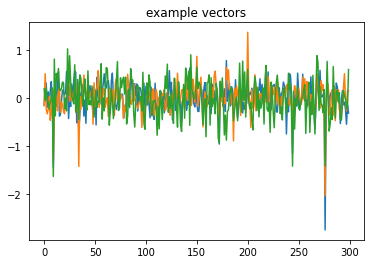

In [49]:
import matplotlib.pyplot as plt
#peeking at the embedding matrix values
print(embedding_matrix.shape)

plt.plot(embedding_matrix[12])
plt.plot(embedding_matrix[46])
plt.plot(embedding_matrix[97])
plt.title('example vectors')

In [50]:
#creating seperate traget data
y= train_data['target']
len(sequences_matrix_data),y.shape

(979591, (979591,))

In [51]:
#converting into numpy_array formate
x_final=np.array(sequences_matrix_data)
y_final=np.array(y)

In [52]:
x_final.shape,y_final.shape

((979591, 100), (979591,))

In [53]:
#spliting the data as we need to validate the data after training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(x_final, y_final , test_size=0.33, random_state=42)

In [54]:
#creating a model with CNN, LSTM and with pretrained glove word embedddings 

def CNN():
    inputs = Input(name='inputs',shape=[max_len])
    
    layer = Embedding(max_num_words+1,300,input_length=max_len,weights=[embedding_matrix], trainable=False)(inputs)
    layer = Dropout(0.2)(layer)
    layer = Conv1D(64, 5, activation = 'relu')(layer)
    layer = MaxPooling1D(pool_size = 4)(layer)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [55]:
model = CNN()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          600300    
_________________________________________________________________
dropout (Dropout)            (None, 100, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            96064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640 

In [56]:
model.compile(loss='binary_crossentropy',optimizer='adam',
              metrics=['accuracy'])

In [57]:
model.fit( X_train,y_train, validation_data=(X_test, y_test), epochs = 2, batch_size=500)

Epoch 1/2
1313/1313 [==============================] - 1269s 963ms/step - loss: 0.2105 - accuracy: 0.9363 - val_loss: 0.1541 - val_accuracy: 0.9456
Epoch 2/2
1313/1313 [==============================] - 1166s 888ms/step - loss: 0.1554 - accuracy: 0.9457 - val_loss: 0.1507 - val_accuracy: 0.9470


In [58]:
test_X=np.array(test_sequences_matrix_data)
test_y =np.array(test_data.target)

In [59]:
pred_y=model.predict(test_X)

In [88]:
pred_y =(pred_y > .6).astype(int)

In [89]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
confusion_matrix(pred_y, test_y)

array([[303156,  19083],
       [  3436,    856]])

In [90]:
accuracy_score(pred_y, test_y)

0.9310356443951723